In [20]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.patches import Patch


In [21]:
input_size = 28*28          # 28x28 images
hidden_size = 256           # Fully connected layer nodes
num_classes = 10            # Fashion MNIST 10 categories
num_epochs = 20             # 15–20 eapochs CPU-ում
batch_size = 128            # CPU-friendly
lr = 1e-3                   # learning rate

In [22]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [23]:
# Data: Train / Test loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # normalize to approx [-1,1]
])

train_dataset = dsets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = dsets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_gen = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_gen  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [24]:
# Model definition (CNN)
class FashionCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 28 -> 14
        self.dropout1 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [25]:
# Instantiate and move to device
net = FashionCNN(num_classes=num_classes).to(device)
print(net)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [26]:
# Loss, optimizer, metrics containers
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [27]:
train_losses = []
test_losses = []
test_accuracies = []
epochs_list = []

In [28]:
# Evaluation function
# Evaluation function
def evaluate_model():
    net.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_gen:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(test_gen)
    accuracy = 100.0 * correct / total
    net.train()
    return avg_loss, accuracy


In [29]:
# Live plotting helper (Jupyter-friendly)
from IPython.display import clear_output

def plot_live():
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    
    # Loss
    ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss')
    ax1.plot(epochs_list, test_losses, 'r-', label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training & Test Loss (Live)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Accuracy
    ax2.plot(epochs_list, test_accuracies, 'g-', label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim([0,100])
    ax2.set_title('Test Accuracy (Live)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

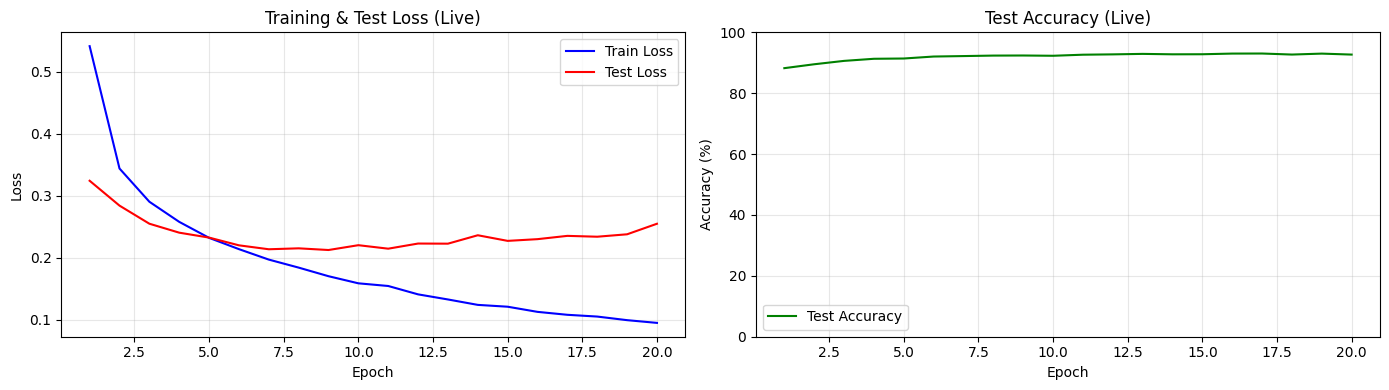

Epoch [20/20] Summary:
  Train Loss: 0.0952
  Test Loss: 0.2549
  Test Accuracy: 92.69%



In [30]:
# Training loop
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    num_batches = 0

    for images, labels in train_gen:
        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_train_loss = epoch_loss / num_batches
    test_loss, test_accuracy = evaluate_model()

    epochs_list.append(epoch+1)
    train_losses.append(avg_train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    plot_live()

    print(f"Epoch [{epoch+1}/{num_epochs}] Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.2f}%\n")


In [45]:
# ----------------------------------------------------------
# Print Accuracy for All Epochs
# ----------------------------------------------------------
print("="*60)
print("TEST ACCURACY BY EPOCH")
print("="*60)

print(f"{'Epoch':<10}{'Accuracy (%)':<15}{'Test Loss':<15}")
print("-" * 40)

for epoch, acc, loss in zip(epochs_list, test_accuracies, test_losses):
    print(f"{epoch:<10}{acc:<15.2f}{loss:<15.4f}")
    
print("-" * 40)

# Max accuracy
max_acc = max(test_accuracies)
max_acc_epoch = epochs_list[test_accuracies.index(max_acc)]

# Lowest test loss
min_loss = min(test_losses)
min_loss_epoch = epochs_list[test_losses.index(min_loss)]

print(f"Max Accuracy: {max_acc:.2f}% (Epoch {max_acc_epoch})")
print(f"Lowest Test Loss: {min_loss:.4f} (Epoch {min_loss_epoch})")
print("="*60)


TEST ACCURACY BY EPOCH
Epoch     Accuracy (%)   Test Loss      
----------------------------------------
1         88.23          0.3241         
2         89.51          0.2841         
3         90.62          0.2549         
4         91.31          0.2405         
5         91.40          0.2326         
6         92.05          0.2201         
7         92.20          0.2138         
8         92.36          0.2153         
9         92.39          0.2126         
10        92.30          0.2203         
11        92.65          0.2147         
12        92.76          0.2230         
13        92.92          0.2228         
14        92.78          0.2363         
15        92.80          0.2273         
16        93.02          0.2301         
17        93.04          0.2353         
18        92.70          0.2340         
19        93.01          0.2379         
20        92.69          0.2549         
----------------------------------------
Max Accuracy: 93.04% (Epoch 17)
Lo

FINAL MODEL PERFORMANCE
Best Test Accuracy: 93.04% (Epoch 17)
Lowest Test Loss: 0.2126 (Epoch 9)
Final Test Accuracy: 92.69%
Final Train Loss: 0.0952
Final Test Loss: 0.2549


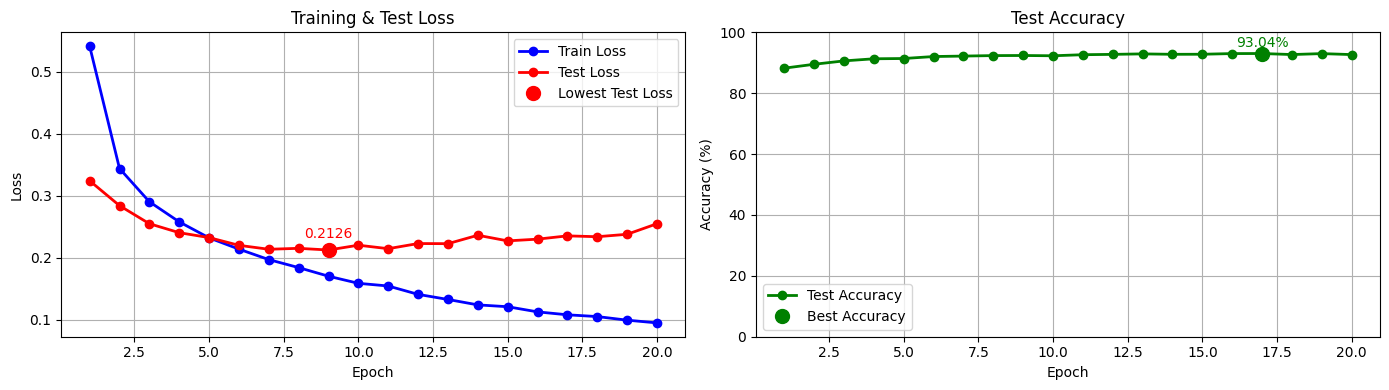

In [ ]:
# Final summary and final plots
print("="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Best Test Accuracy: {max(test_accuracies):.2f}% (Epoch {epochs_list[np.argmax(test_accuracies)]})")
print(f"Lowest Test Loss: {min(test_losses):.4f} (Epoch {epochs_list[np.argmin(test_losses)]})")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Test Loss: {test_losses[-1]:.4f}")
print("="*60)

# Final plots with markers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Loss curves with markers
ax1.plot(epochs_list, train_losses, 'b-o', label='Train Loss', linewidth=2, markersize=6)
ax1.plot(epochs_list, test_losses, 'r-o', label='Test Loss', linewidth=2, markersize=6)

# Highlight lowest test loss
best_loss_epoch = epochs_list[np.argmin(test_losses)]
best_loss_value = min(test_losses)
ax1.plot(best_loss_epoch, best_loss_value, 'ro', markersize=10, label='Lowest Test Loss')
ax1.text(best_loss_epoch, best_loss_value + 0.02, f'{best_loss_value:.4f}', color='red', fontsize=10, ha='center')



ax1.set_title("Training & Test Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Accuracy curve with markers
ax2.plot(epochs_list, test_accuracies, 'g-o', label='Test Accuracy', linewidth=2, markersize=6)

# Highlight best accuracy
best_acc_epoch = epochs_list[np.argmax(test_accuracies)]
best_acc_value = max(test_accuracies)
ax2.plot(best_acc_epoch, best_acc_value, 'go', markersize=10, label='Best Accuracy')
ax2.text(best_acc_epoch, best_acc_value + 2, f'{best_acc_value:.2f}%', color='green', fontsize=10, ha='center')

ax2.set_title("Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True)
ax2.set_ylim([0, 100])
ax2.legend()

plt.tight_layout()
plt.show()



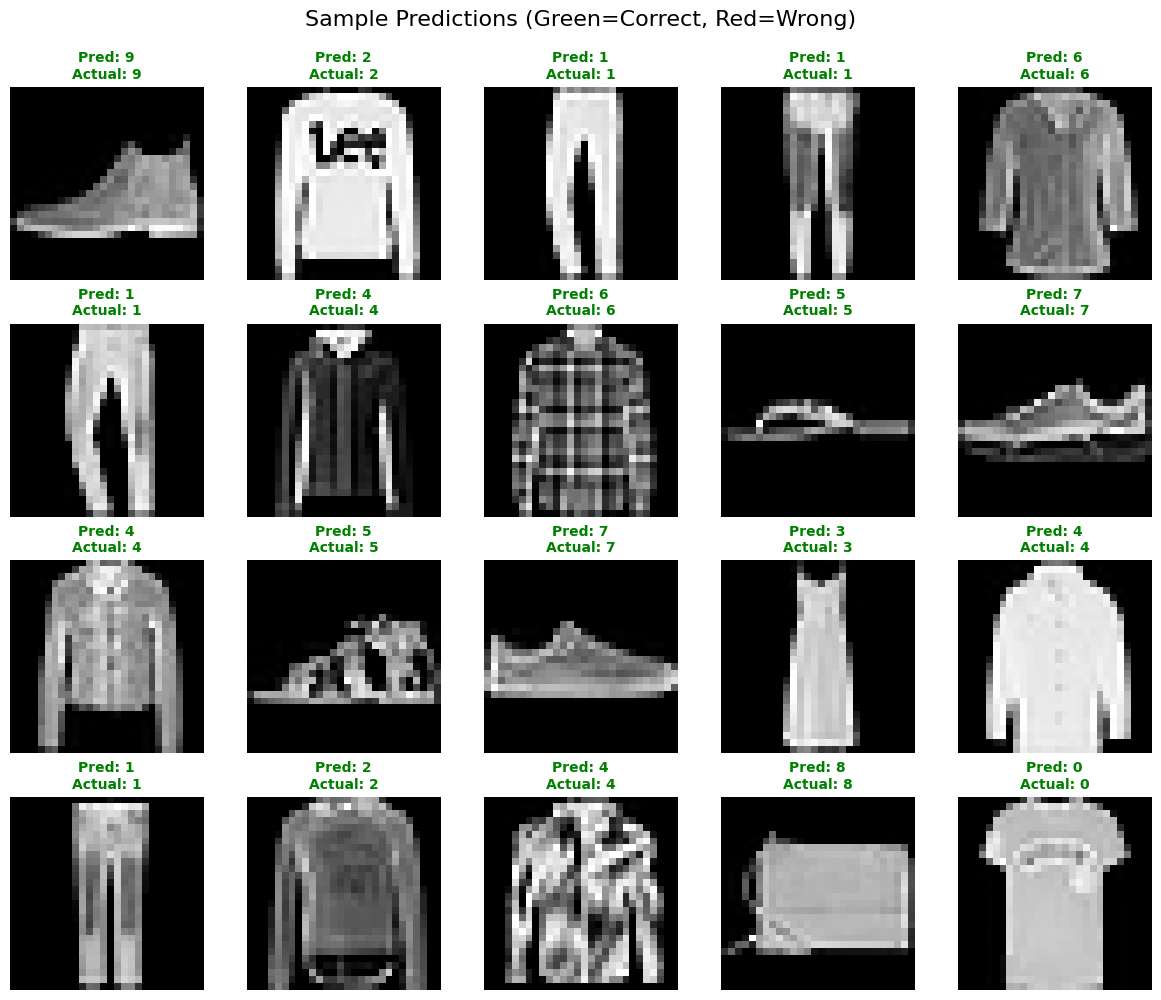

In [59]:
# Visualize Sample Predictions
dataiter = iter(test_gen)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)

net.eval()
with torch.no_grad():
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

images_np = images.cpu().numpy()
predicted_np = predicted.cpu().numpy()
labels_np = labels.cpu().numpy()

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=16, y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(images_np):
        ax.imshow(images_np[idx].squeeze(), cmap='gray')
        is_correct = predicted_np[idx] == labels_np[idx]
        color = 'green' if is_correct else 'red'
        ax.set_title(f'Pred: {predicted_np[idx]}\nActual: {labels_np[idx]}', fontsize=10, color=color, weight='bold')
        ax.axis('off')

plt.tight_layout()
plt.show()


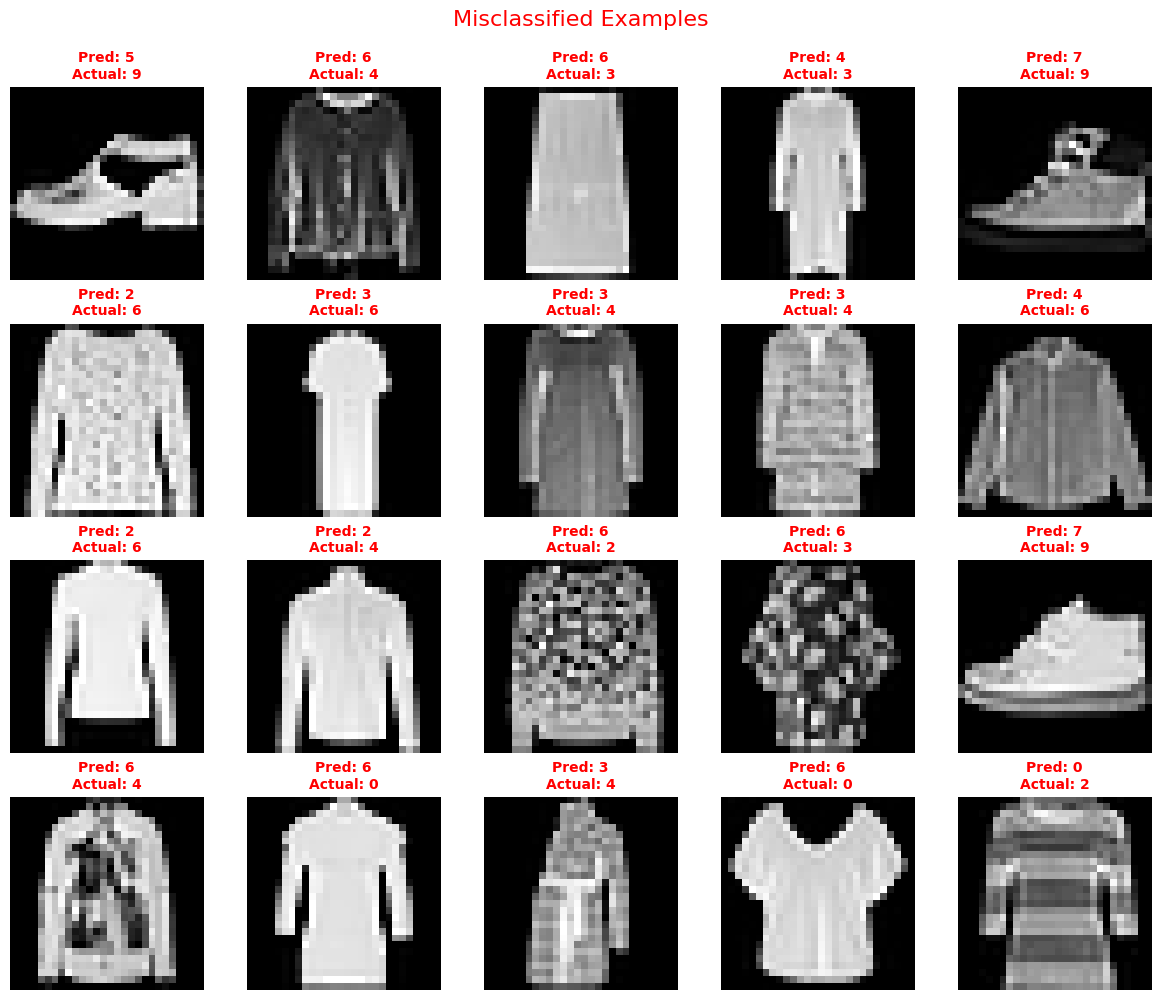

In [60]:
# Find and Display Misclassified Examples
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_gen:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in wrong_idx:
            if len(misclassified_images) < 20:
                misclassified_images.append(images[idx].cpu().numpy())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(predicted[idx].item())
        if len(misclassified_images) >= 20:
            break

if len(misclassified_images) > 0:
    num_examples = min(20, len(misclassified_images))
    rows = (num_examples + 4) // 5
    fig, axes = plt.subplots(rows, 5, figsize=(12, 2.5 * rows))
    fig.suptitle('Misclassified Examples', fontsize=16, color='red', y=0.995)

    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx, ax in enumerate(axes.flat):
        if idx < num_examples:
            ax.imshow(misclassified_images[idx].squeeze(), cmap='gray')
            ax.set_title(f'Pred: {misclassified_preds[idx]}\nActual: {misclassified_labels[idx]}', fontsize=10, color='red', weight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print('No misclassified examples found in the test set!')

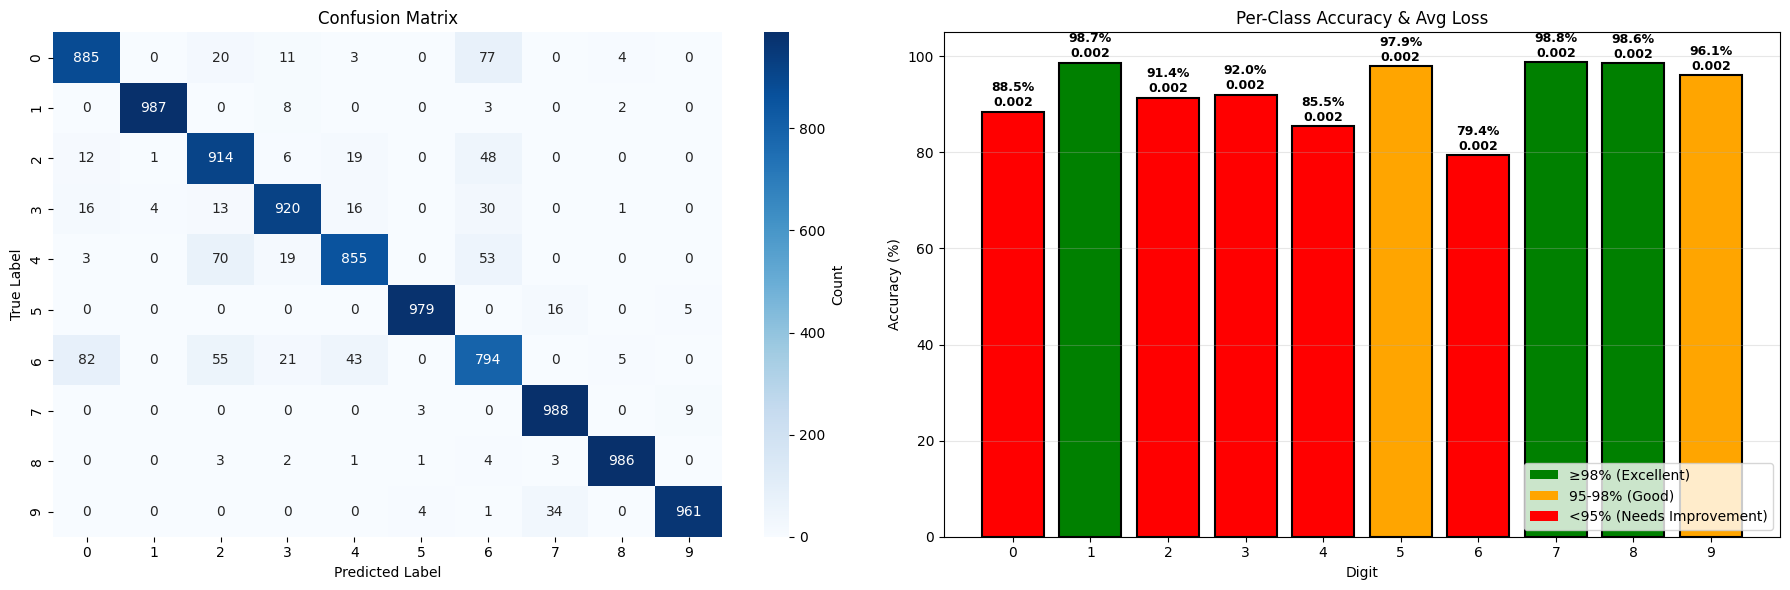

PER-CLASS PERFORMANCE
Digit Accuracy (%)   Avg Loss    Correct/Total  Errors  
--------------------------------------------------------------------------------
0     88.50          0.0020      885/1000           115     
1     98.70          0.0020      987/1000           13      
2     91.40          0.0021      914/1000           86      
3     92.00          0.0020      920/1000           80      
4     85.50          0.0020      855/1000           145     
5     97.90          0.0020      979/1000           21      
6     79.40          0.0021      794/1000           206     
7     98.80          0.0020      988/1000           12      
8     98.60          0.0020      986/1000           14      
9     96.10          0.0020      961/1000           39      
Overall Accuracy: 92.69%

Most Confused Pairs (top 5):
1. Digit 6 misclassified as 0: 82 times
2. Digit 0 misclassified as 6: 77 times
3. Digit 4 misclassified as 2: 70 times
4. Digit 6 misclassified as 2: 55 times
5. Digit 4 misc

In [64]:
# ----------------------------------------------------------
# Confusion Matrix, Per-Class Accuracy & Per-Class Loss
# ----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Patch
import torch
from torch.autograd import Variable

all_predictions = []
all_labels = []

# Initialize per-class loss accumulator
num_classes = 10
class_losses = [0.0] * num_classes
class_counts = [0] * num_classes

# Evaluate model on test set
net.eval()
with torch.no_grad():
    for images, labels in test_gen:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        loss = loss_function(outputs, labels)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # accumulate per-class loss and count
        for i in range(len(labels)):
            cls = labels[i].item()
            class_losses[cls] += loss.item() / len(labels)  # batch-normalized
            class_counts[cls] += 1

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_predictions)

# Per-class accuracy & average loss
class_accuracies = []
class_avg_losses = []
for cls in range(num_classes):
    mask = all_labels == cls
    correct = (all_predictions[mask] == cls).sum()
    total = mask.sum()
    accuracy = 100 * correct / total if total > 0 else 0
    avg_loss = class_losses[cls] / max(class_counts[cls], 1)
    class_accuracies.append(accuracy)
    class_avg_losses.append(avg_loss)

# Plot confusion matrix and per-class metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title('Confusion Matrix')

# Per-class accuracy & loss bar plot
digits = list(range(num_classes))
colors = ['green' if acc >= 98 else 'orange' if acc >= 95 else 'red' for acc in class_accuracies]
bars = ax2.bar(digits, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)

for i, (bar, acc, loss) in enumerate(zip(bars, class_accuracies, class_avg_losses)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5, f'{acc:.1f}%\n{loss:.3f}', 
             ha='center', va='bottom', fontsize=9, weight='bold')

ax2.set_xlabel('Digit')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Per-Class Accuracy & Avg Loss')
ax2.set_ylim([0, 105])
ax2.set_xticks(digits)
ax2.grid(True, alpha=0.3, axis='y')

legend_elements = [
    Patch(facecolor='green', label='≥98% (Excellent)'),
    Patch(facecolor='orange', label='95-98% (Good)'),
    Patch(facecolor='red', label='<95% (Needs Improvement)')
]
ax2.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("="*80)
print("PER-CLASS PERFORMANCE")
print("="*80)
print(f"{'Digit':<6}{'Accuracy (%)':<15}{'Avg Loss':<12}{'Correct/Total':<15}{'Errors':<8}")
print("-"*80)
for cls, acc, loss, count in zip(range(num_classes), class_accuracies, class_avg_losses, class_counts):
    correct = int(acc * count / 100)
    errors = count - correct
    print(f"{cls:<6}{acc:<15.2f}{loss:<12.4f}{correct}/{count:<15}{errors:<8}")

overall_acc = 100 * (all_predictions == all_labels).sum() / len(all_labels)
print("="*80)
print(f'Overall Accuracy: {overall_acc:.2f}%')
print("="*80)

# Most confused pairs
confused_pairs = [(i, j, cm[i, j]) for i in range(num_classes) for j in range(num_classes) if i != j and cm[i, j] > 0]
confused_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nMost Confused Pairs (top 5):")
for idx, (true, pred, count) in enumerate(confused_pairs[:5]):
    print(f"{idx+1}. Digit {true} misclassified as {pred}: {count} times")
